# Take-Home challenge

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Part 1 ‐ Exploratory data analysis 
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [31]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [32]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [33]:
logins['login_time'].min(), logins['login_time'].max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [34]:
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins['count'] = 1
logins.set_index('login_time',inplace=True)
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [35]:
counts_15m = logins.resample('15T').count()
counts_15m.value_counts()

count
2        726
4        706
3        703
5        658
1        638
        ... 
56         1
63         1
64         1
66         1
73         1
Name: count, Length: 62, dtype: int64

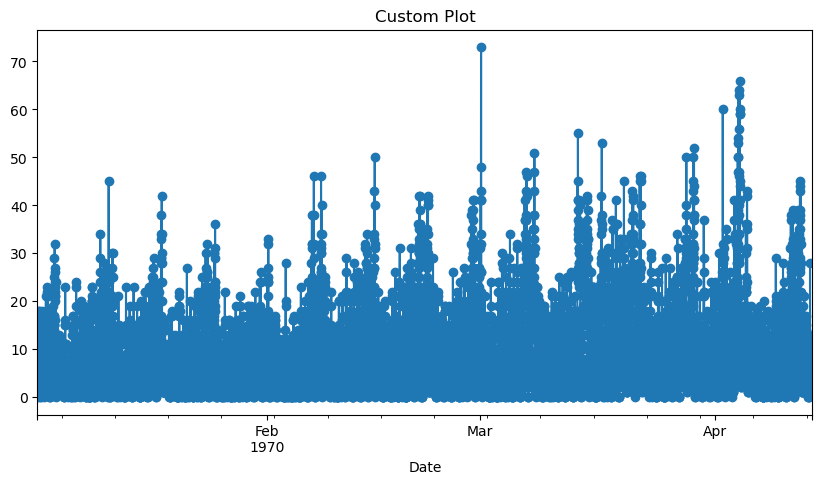

In [36]:
plt.figure(figsize=(10,5))
counts_15m['count'].plot(kind='line', marker='o')
plt.title('Custom Plot')
plt.xlabel('Date')
plt.ylabel('')
plt.show()

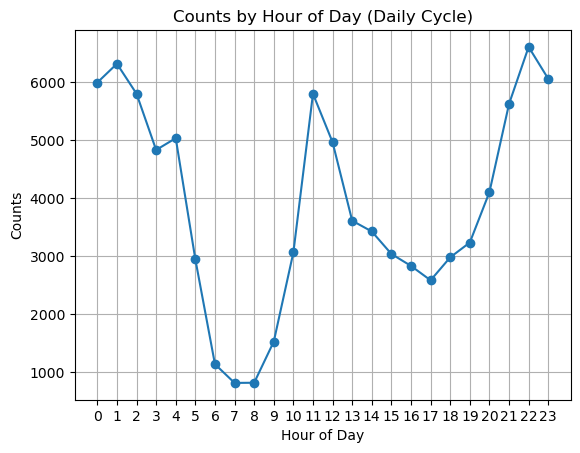

In [37]:
# Extract hour of day
logins.reset_index(inplace=True)
logins['hour'] = logins['login_time'].dt.hour

# Aggregate counts by hour
daily_cycle = logins.groupby('hour')['count'].sum()

# Plot daily cycle
daily_cycle.plot(kind='line', marker='o')
plt.title('Counts by Hour of Day (Daily Cycle)')
plt.xlabel('Hour of Day')
plt.ylabel('Counts')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

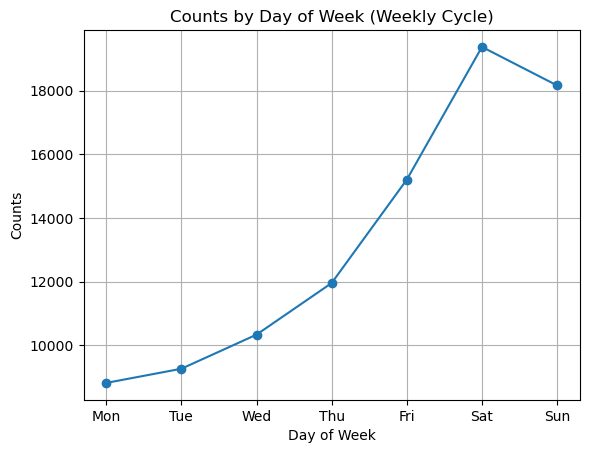

In [38]:
# Extract day of week
logins['day'] = logins['login_time'].dt.dayofweek

# Aggregate counts by hour
weekly_cycle = logins.groupby('day')['count'].sum()
days=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
# Plot daily cycle
weekly_cycle.plot(kind='line', marker='o')
plt.title('Counts by Day of Week (Weekly Cycle)')
plt.xlabel('Day of Week')
plt.ylabel('Counts')
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=days)
plt.grid(True)
plt.show()

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate **Gotham** is most active at **night**, and Ultimate **Metropolis** is most active during the **day**. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

**Answer:** The key measure of success is the increase in the percentage of drivers completing trips in both Gotham and Metropolis. This metric best captures whether the toll reimbursement is reducing city exclusivity and successfully encouraging cross-city driver participation, which is the core goal of the experiment. In contrast, the absolute number of toll usages does not account for sample size and can lead to inconsistent or misleading conclusions.

**2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a) how you will implement the experiment** <br>
**Answer:**
* Experimental design:<br>
Randomized Controlled Trial (RCT), which is suitable for causal inference.

* Population:<br>
All active drivers in Gotham or Metropolis who have only driven in one city historically for a period of time, e.g., in the past 4–6 weeks.
These are drivers who have shown a city-exclusive behavior. In cases of limited sample size, it may be necessary to slightly relax the exclusivity criteria.

* Random assignment:<br>
*Treatment Group*: Receives toll reimbursement for cross-city trips.<br>
*Control Group*: Continues under current toll conditions (no reimbursement).<br>
Randomization should be done at the driver level, stratified by city and driving activity to ensure balance.

* Duration:<br>
Run the experiment for 4–6 weeks, covering both weekdays and weekends to capture differences in circadian patterns.

* Measurements:<br>
Track the total number of completed trips for each driver in both cities on a daily or weekly basis. Toll usage and driving hours can be used as supporting features.

**b) what statistical test(s) you will conduct to verify the significance of the observation**<br>
**Answer:**
With the proportion of drivers completing trips in both cities per week as a metric, perform one-tailed Z-test if the measurements are normally distributed; use bootstrap method otherwise.<br>
Null hypothesis:  $p_{treatment} = p_{controlled}$<br>
Alternative hypothesis: $p_{treatment} > p_{controlled}$<br>

**c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.** <br>
**Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.** <br>
**Answer:** If the increase in the percentage of drivers completing trips in both Gotham and Metropolis is statistically significant, the null hypothesis can be rejected, and the results can be interpreted as evidence that the toll reimbursement policy led to an increase in cross-city driving among previously city-exclusive drivers. In this case, we can recommend the city operations team that they roll out toll reimbursement to all drivers, or target specific segments where the effect was strongest, e.g., high-activity night drivers in Gotham.
The team should also keep monitoring for increased demand-supply balance in both cities and adjust incentives or messaging based on driver response patterns.



## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
- Q1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
- Q2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
- Q3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

**Answer to Q1:** Three features contained missing values. For numeric features, missing values were filled with the median; for categorical features, 'etc' was used. The fraction of retained customers was 37.6%. 

In [39]:
df_retention = pd.read_json('ultimate_data_challenge.json')

In [40]:
df_retention.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [41]:
df_retention.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [42]:
df_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [43]:
df_retention[['avg_rating_of_driver','avg_rating_by_driver']]=\
df_retention[['avg_rating_of_driver','avg_rating_by_driver']].apply(lambda x: x.fillna(x.median())) 
df_retention.fillna({'phone': 'etc'},inplace=True)
df_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [44]:
import datetime as dt
df_retention['signup_date'] = pd.to_datetime(df_retention['signup_date'], format='%Y-%m-%d')
df_retention['last_trip_date'] = pd.to_datetime(df_retention['last_trip_date'], format='%Y-%m-%d')
df_retention['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [45]:
df_retention['retained'] = df_retention['last_trip_date'].dt.month >= 6
df_retention = df_retention.sort_values('signup_date').reset_index()
df_retention = df_retention.drop('index',axis=1)
df_retention['date_index'] = df_retention.index
df_retention[['signup_date','last_trip_date','date_index', 'retained']] 

,signup_date,last_trip_date,date_index,retained
0,2014-01-01,2014-06-28,0,True
1,2014-01-01,2014-01-01,1,False
2,2014-01-01,2014-06-08,2,True
3,2014-01-01,2014-06-20,3,True
4,2014-01-01,2014-05-18,4,False
...,...,...,...,...
49995,2014-01-31,2014-04-08,49995,False
49996,2014-01-31,2014-03-13,49996,False
49997,2014-01-31,2014-07-01,49997,True
49998,2014-01-31,2014-06-27,49998,True


In [46]:
#df_retention['retained'].count()
#df_retention[(df_retention['retained'] == True)].retained.count()
print(f"fraction of retained customers: {100*df_retention[(df_retention['retained'] == True)].retained.count()/df_retention['retained'].count():2.1f}%")

fraction of retained customers: 37.6%


<Axes: ylabel='weekday_pct'>

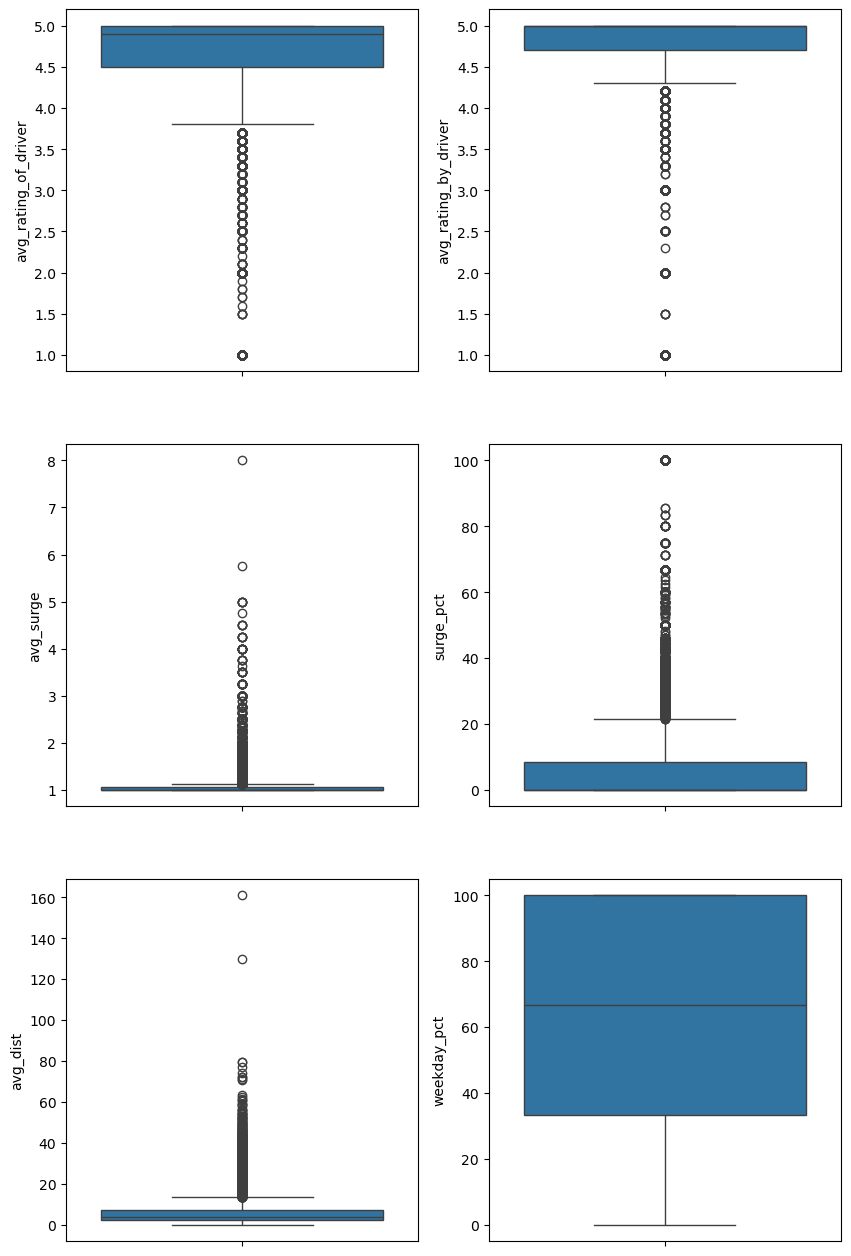

In [47]:
fig, ax = plt.subplots(3,2,figsize=(10,16))
sns.boxplot(data=df_retention, y='avg_rating_of_driver', ax = ax[0,0])
sns.boxplot(data=df_retention, y='avg_rating_by_driver', ax = ax[0,1])
sns.boxplot(data=df_retention, y='avg_surge', ax = ax[1,0])
sns.boxplot(data=df_retention, y='surge_pct', ax = ax[1,1])
sns.boxplot(data=df_retention, y='avg_dist', ax = ax[2,0])
sns.boxplot(data=df_retention, y='weekday_pct', ax = ax[2,1])

In [48]:
dfo = df_retention.select_dtypes(include=['object','bool'], exclude=['datetime'])
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)

,VarName,LevelsCount
0,city,3
1,phone,3
2,ultimate_black_user,2
3,retained,2


In [49]:
df =  pd.get_dummies(df_retention)
df_numeric = df.select_dtypes(include=[np.number,'bool']) 

In [50]:
df_numeric.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'date_index', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android', 'phone_etc',
       'phone_iPhone'],
      dtype='object')

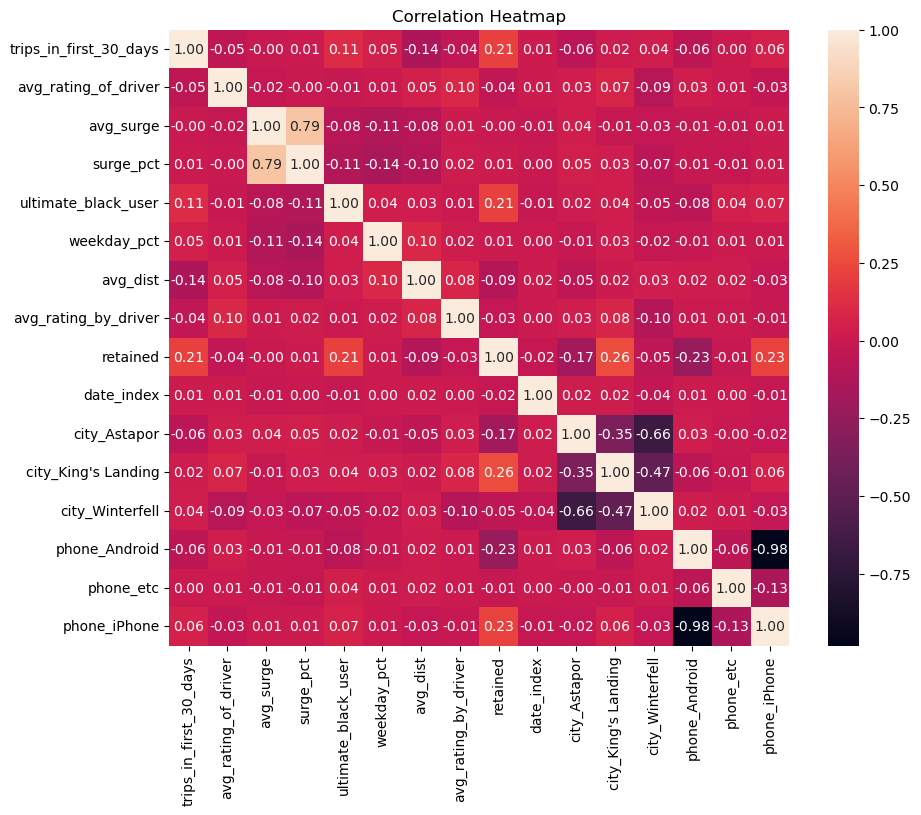

In [51]:
plt.figure(figsize=(10, 8)) # Optional: Adjust figure size
sns.heatmap(df_numeric.corr(),annot=True,fmt=".2f");
plt.title('Correlation Heatmap')
plt.show()

**Answer to Q2:** In order to predict whether or not a user will be active in their 6th month on the system, we choose gradient boosting ensemble approach. Alternative approches include logistic regression and random forest. Logistic regression does not handle correlated predictors well, whereas Gradient Boosting is better suited for imbalanced datasets and complex problems due to its ability to incorporate stronger regularization. The selected model achieves an accuracy of 80%. 

In [52]:
from sklearn.metrics import precision_recall_curve, f1_score, auc,roc_curve,roc_auc_score
from sklearn.metrics import classification_report,multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [53]:
y= df_numeric['retained']
X= df_numeric.drop(columns = ['retained'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [54]:
#clf = RandomForestClassifier(n_estimators=500, random_state = 1,n_jobs=-1)
clf = GradientBoostingClassifier(n_estimators=500, max_features=4, max_depth = 3, random_state = 1)
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
#lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = multilabel_confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.797
Random Forest: f1-score=0.794


In [55]:
import shap

explainer = shap.TreeExplainer(clf,feature_names = X.columns)
shap_values = explainer(X_test).values

positive = shap_values

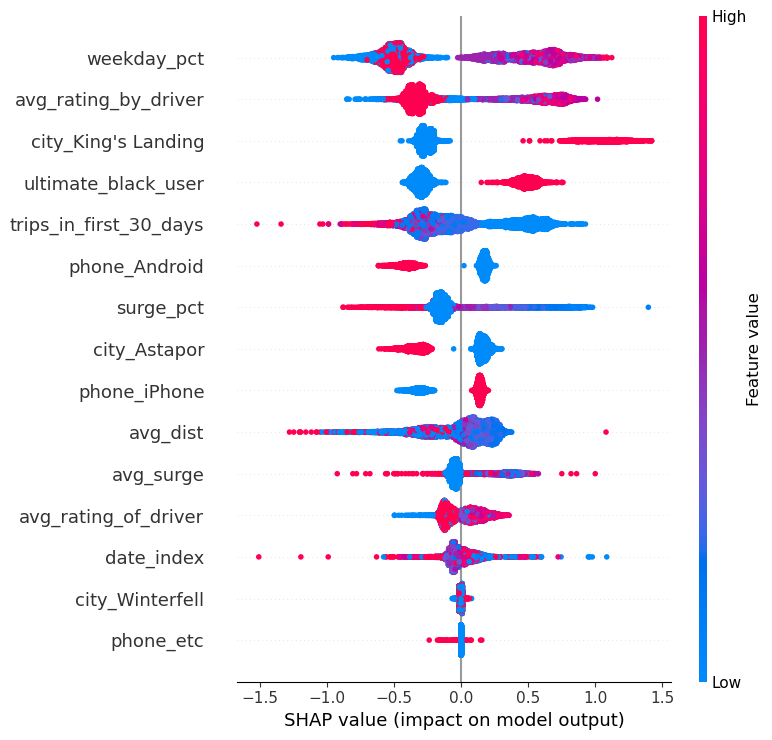

In [56]:
shap.summary_plot(positive, X_test,feature_names = X.columns)

**Answer to Q3:** The strongest factors influencing long-term rider retention include the rider's location, particularly in King's Landing, using Ultimate Black within the first 30 days, and being an iPhone user. Ultimate can leverage these insights to encourage early use of Ultimate Black and implement targeted advertising strategies to boost retention. Additionally, analyzing the lower long-term retention rates among users in Astapor and on Android devices, and identifying ways to improve performance in these segments, could further enhance overall retention. 